Importing required libraries.

In [111]:
import numpy as np
import matplotlib.pyplot as plt

Reading data from file.

In [112]:
traindata = np.loadtxt('./traindata.txt')

X_train = traindata[:, :-1]
Y_train = traindata[:, -1]

baseline_rss = np.var(Y_train)
print(f"Baseline mean RSS: {baseline_rss}")

X_test = np.loadtxt('./testinputs.txt')

Baseline mean RSS: 282.8777177208458


Function to calculate the weight vector from given design matrix and actual output data. Also using L2 Regularization. 

In [113]:
def solve(Z, y, lam = 0.0):
    d = Z.shape[0]

    return np.linalg.solve(Z @ Z.T + lam * np.eye(d), Z @ y)

Function to calculate Residual Sum of Squares (RSS) given weight vector, design matrix, and actual output data. 

In [114]:
def RSS(W, Z, y):
    return np.mean(((Z.T @ W) - y) ** 2)

Calculating the design matrix for given polynomial order. From experiments, we found that not having interaction items gave better results. Also, we found that including sqrt(x) as a feature helped. 

In [115]:
def design_matrix(x, p): # version without interaction items.  
    n, d = x.shape
    features = [np.ones((n, 1))]  # for bias
    
    for j in range(d):           
        col = x[:, j]
        feat_sqrt = (np.sqrt(col)).reshape(-1, 1) # sqrt as a feature
        features.append(feat_sqrt)
        for degree in range(1, p+1):    
            feat_pol = (col ** degree).reshape(-1, 1) # polynomial features
            features.append(feat_pol)

    return np.hstack(features)

K-fold Cross Validation code.

In [116]:
def kfold_cv(x, y, p, K, lam = 0.0):
    Z  = design_matrix(x, p).T 

    N = y.shape[0]
    test_Rs = []
    train_Rs = []
    
    for fold in range(K):
        start = int(fold / K * N)
        end = int((fold + 1) / K * N)

        # boolean mask
        mask = np.ones(N, dtype=bool)
        mask[start:end] = False # test indices set to False

        # split as per the mask
        train_x, train_y = Z[:, mask], y[mask, :]
        test_x,  test_y  = Z[:, ~mask], y[~mask, :]

        # fit on train
        W = solve(train_x, train_y, lam)

        # compute residuals
        train_R = RSS(W, train_x, train_y)
        test_R = RSS(W, test_x, test_y)

        test_Rs.append(test_R)
        train_Rs.append(train_R)
        
    return np.sum(train_Rs) / len(train_Rs), np.sum(test_Rs) / len(test_Rs)

Doing cross-validation on different orders of polynomial. We found that K = 690 and lambda = 100 gave the best results. Also, going beyond order of 8 started causing weird behaviors, presumably because of numerical instabilities. The K = 690 basically means that we are doing Leave-one-out Cross Validation, which was computationally doable in our case.

In [117]:
test_cvs = []
train_cvs = []
order_range = 11 

for order in range(1, order_range):
    train_cv, test_cv = kfold_cv(X_train, Y_train.reshape(-1, 1), p = order, K = 690, lam = 100)

    train_cvs.append(train_cv)
    test_cvs.append(test_cv)

Plotting average validation errors and average training errors from k-fold Cross Validation of each basis expansion .

[np.float64(46.487314962895155), np.float64(43.37116940775294), np.float64(40.84612415676031), np.float64(37.58005695677805), np.float64(34.70926287051113), np.float64(33.38622682517554), np.float64(31.242855281337256), np.float64(29.884212806194874), np.float64(31.04098657704731), np.float64(28.8308661576515)]
[np.float64(46.981778632229755), np.float64(44.93180557998208), np.float64(42.92660952158656), np.float64(40.408742458756585), np.float64(37.12320243765725), np.float64(36.45728622224767), np.float64(34.68739329449103), np.float64(33.42420485675323), np.float64(33.881094774466206), np.float64(35.10980028390671)]


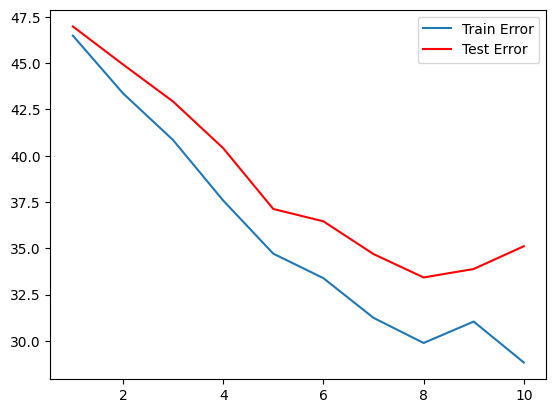

In [118]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

plt.plot([i for i in range(1, order_range)], train_cvs, label = "Train Error")
print(train_cvs)
plt.plot([i for i in range(1, order_range)], test_cvs, label = "Test Error", color = 'red')
print(test_cvs)
plt.legend()

plt.show()

Fitting on the entire dataset.

In [119]:
Z_full_train = design_matrix(X_train, 8).T

W_final = solve(Z_full_train, Y_train, 100)

error = RSS(W_final, Z_full_train, Y_train)
improvement = (baseline_rss - error) / baseline_rss

f"Mean SSE: {error}", f"The model reduces error by {improvement * 100} % compared to baseline."

('Mean SSE: 29.88738812889099',
 'The model reduces error by 89.43452019844668 % compared to baseline.')

Finally, predicting the outputs of the given test set. 

In [120]:
Z_test = design_matrix(X_test, 8)

y_test_predicted = Z_test @ W_final

y_test_predicted

array([70.33754323, 39.29826165, 45.47524086, 51.60108036, 48.88570505,
       40.8106514 , 51.37768028, 42.01882442, 38.64728457, 48.76167956,
       44.26143128, 50.76768615, 52.84730768, 58.00253907, 58.68471432,
       63.83617548, 67.77711667, 69.25666391, 72.59755234, 19.22495393,
       24.0508279 , 21.67694719, 18.73209616, 33.49371785, 21.59648749,
       24.04735748, 26.61605323, 27.36824384, 26.14373356, 25.02635089,
       32.65312932, 32.20525092, 29.94905781, 38.85765152, 33.40944486,
       32.81043284, 43.00403927, 29.15397832, 62.86910455, 48.33396376,
       56.77801953, 12.89449666, 28.96552227, 20.16995477, 29.31113535,
       45.76111759, 47.38057642, 42.53889041, 39.73387759, 33.54172767,
       53.44099216, 39.3816106 , 17.99014544, 63.46945547, 24.34472445,
       24.13193908, 32.24778876, 25.89091356, 31.88260279,  9.49510322,
       22.38076928, 29.61717806, 31.25109605, 22.38904499, 25.14266158,
       31.50831907, 30.83711488, 42.97466863, 22.52761337, 28.93